# Import packages

In [1]:
from ast import literal_eval
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
RESULTS_TOTAL_FILEPATH = r'Second model results\forward_total.csv'
RESULTS_WEEKDAYS_FILEPATH = r'Second model results\forward_weekday'

# RESULTS_TOTAL_FILEPATH = r'Second model results\forward_weekday_0.csv'

DISTRIBUTION = stats.exponnorm
DISTRIBUTION_NAME = 'exponnorm'
PERCENTILE = 95

RESULTS_TOTAL_FILEPATH = f"{RESULTS_TOTAL_FILEPATH[:-4]}_{DISTRIBUTION_NAME}.csv"

# Load data

In [3]:
forward_result_total = pd.read_csv(RESULTS_TOTAL_FILEPATH)
forward_result_total['dist_params'] = [literal_eval(dist_params) for dist_params in forward_result_total['dist_params'].values]
if 'Unnamed: 0' in forward_result_total.columns:
    forward_result_total = forward_result_total.drop(columns=['Unnamed: 0'])
forward_result_total.head(5)

,timestep,from_stop,to_stop,dist_params
0,5.0,A01/C01,A02,"[1.6932084843842516, -46.61632500463405, 10.47..."
1,6.0,A01/C01,A02,"[1.4724190201183482, -43.87800761255711, 11.90..."
2,7.0,A01/C01,A02,"[1.4121326845647255, -38.864132458264876, 12.0..."
3,8.0,A01/C01,A02,"[1.2850950019381768, -33.17069368712228, 13.88..."
4,9.0,A01/C01,A02,"[1.9929803709128393, -38.393698881037736, 10.6..."


In [4]:
weekday_results = {}
for weekday in range(7):
    results_i = pd.read_csv(f"{RESULTS_WEEKDAYS_FILEPATH}_{weekday}_{DISTRIBUTION_NAME}.csv")
    results_i['dist_params'] = [literal_eval(dist_params) for dist_params in results_i['dist_params'].values]
    if 'Unnamed: 0' in results_i.columns:
        results_i = results_i.drop(columns=['Unnamed: 0'])
    weekday_results[weekday] = results_i

# Get means, highs, lows

In [5]:
# For total result
means = []
highs = []
lows = []

high_percentile = ((PERCENTILE / 2) + 50) / 100
low_percentile = (50 - (PERCENTILE / 2)) / 100
print(high_percentile, low_percentile)

for index, result in forward_result_total.iterrows():
    # print(index)
    dist_params = result['dist_params']

    means.append(DISTRIBUTION.mean(*dist_params))
    highs.append(DISTRIBUTION.ppf(high_percentile, *dist_params))
    lows.append(DISTRIBUTION.ppf(low_percentile, *dist_params))

forward_result_total['mean'] = means
forward_result_total['high'] = highs
forward_result_total['low'] = lows

0.975 0.025


In [6]:
# For weekday results

for weekday, result_i in weekday_results.items():
    print(weekday)
    means = []
    highs = []
    lows = []

    high_percentile = ((PERCENTILE / 2) + 50) / 100
    low_percentile = (50 - (PERCENTILE / 2)) / 100

    for index, result in result_i.iterrows():
        # print(index)
        dist_params = result['dist_params']

        means.append(DISTRIBUTION.mean(*dist_params))
        highs.append(DISTRIBUTION.ppf(high_percentile, *dist_params))
        lows.append(DISTRIBUTION.ppf(low_percentile, *dist_params))

    result_i['mean'] = means
    result_i['high'] = highs
    result_i['low'] = lows

0
1
2
3
4
5
6


# Results Tables

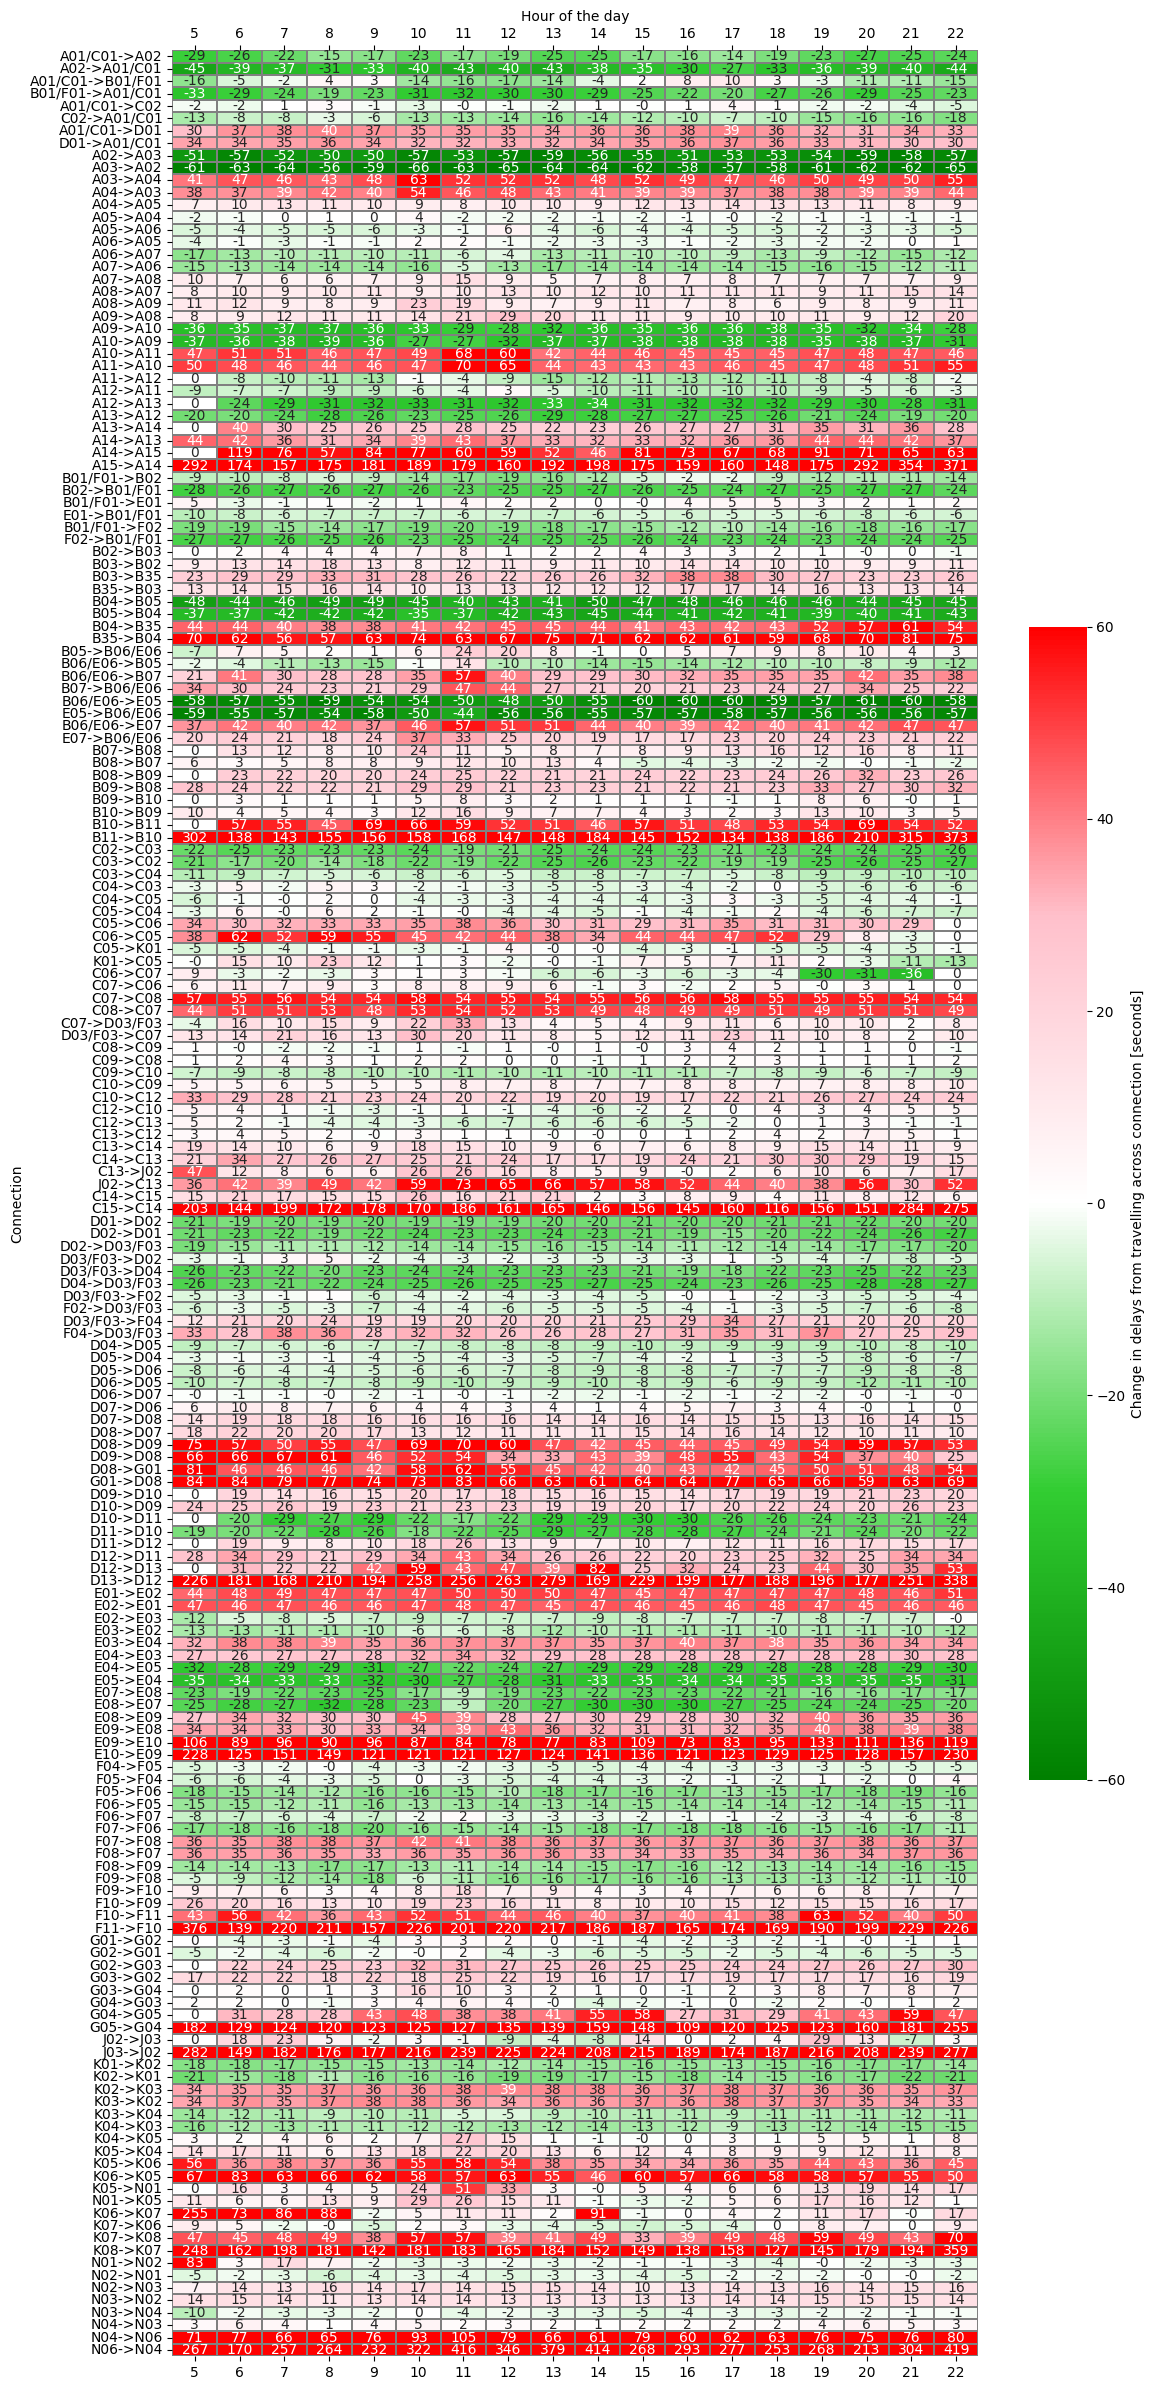

In [7]:
data_dict = {}
stop_pairs = [sorted(list(key)) for key, _ in forward_result_total.groupby(['from_stop', 'to_stop'])]
stop_pairs = np.unique(stop_pairs, axis=0)
stop_pairs.sort()

data_array = []
xticks = [int(timestep) for timestep in forward_result_total['timestep'].unique()]
yticks = []
for stop_pair in stop_pairs:
    # Remove non-existent connections
    if tuple(stop_pair) in [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')]:
                continue

    for stop_pair in [stop_pair, [str(stop_pair[1]), str(stop_pair[0])]]:
        # Remove extreme end-of-line values
        # if tuple(stop_pair) in [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')]:
        #     continue

        functions = forward_result_total[(forward_result_total['from_stop'] == stop_pair[0]) & (forward_result_total['to_stop'] == stop_pair[1])].copy()
        functions = functions.sort_values(by=['timestep'])

        means_i = [0] * len(xticks)
        for _, function in functions.iterrows():
            means_i[int(function['timestep'] - 5)] = function['mean']
        
        data_array.append(means_i)
        yticks.append(f"{str(stop_pair[0])}->{str(stop_pair[1])}")
data_array = np.array(data_array)


fig, ax = plt.subplots(figsize=(12, 24))
# cmap = LinearSegmentedColormap.from_list('', ['red', 'pink', 'white', 'chartreuse', 'limegreen'])
cmap = LinearSegmentedColormap.from_list('', ['green', 'limegreen', 'white', 'pink', 'red'])
# divnorm = TwoSlopeNorm(vmin=-60, vcenter=0., vmax=60)

divnorm = TwoSlopeNorm(vmin=-60, vcenter=0, vmax=60)

sns.heatmap(data_array, xticklabels=xticks, yticklabels=yticks, cmap=cmap, annot=True, fmt='.0f', norm=divnorm, ax=ax, 
            cbar_kws={'label': "Change in delays from travelling across connection [seconds]", "shrink": 0.5},linewidths=0.05,linecolor="grey")


ax.set_xlabel('Hour of the day')
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.xaxis.set_label_position('top')
ax.set_ylabel('Connection')

# ax.set_title('Mean effect on delay when travelling across a connection')
# plt.savefig(r'Model results\forward_table.png', dpi=200)
plt.tight_layout()
plt.show()
fig.savefig(r"Codebase figures\\mean_table.png", dpi=200)

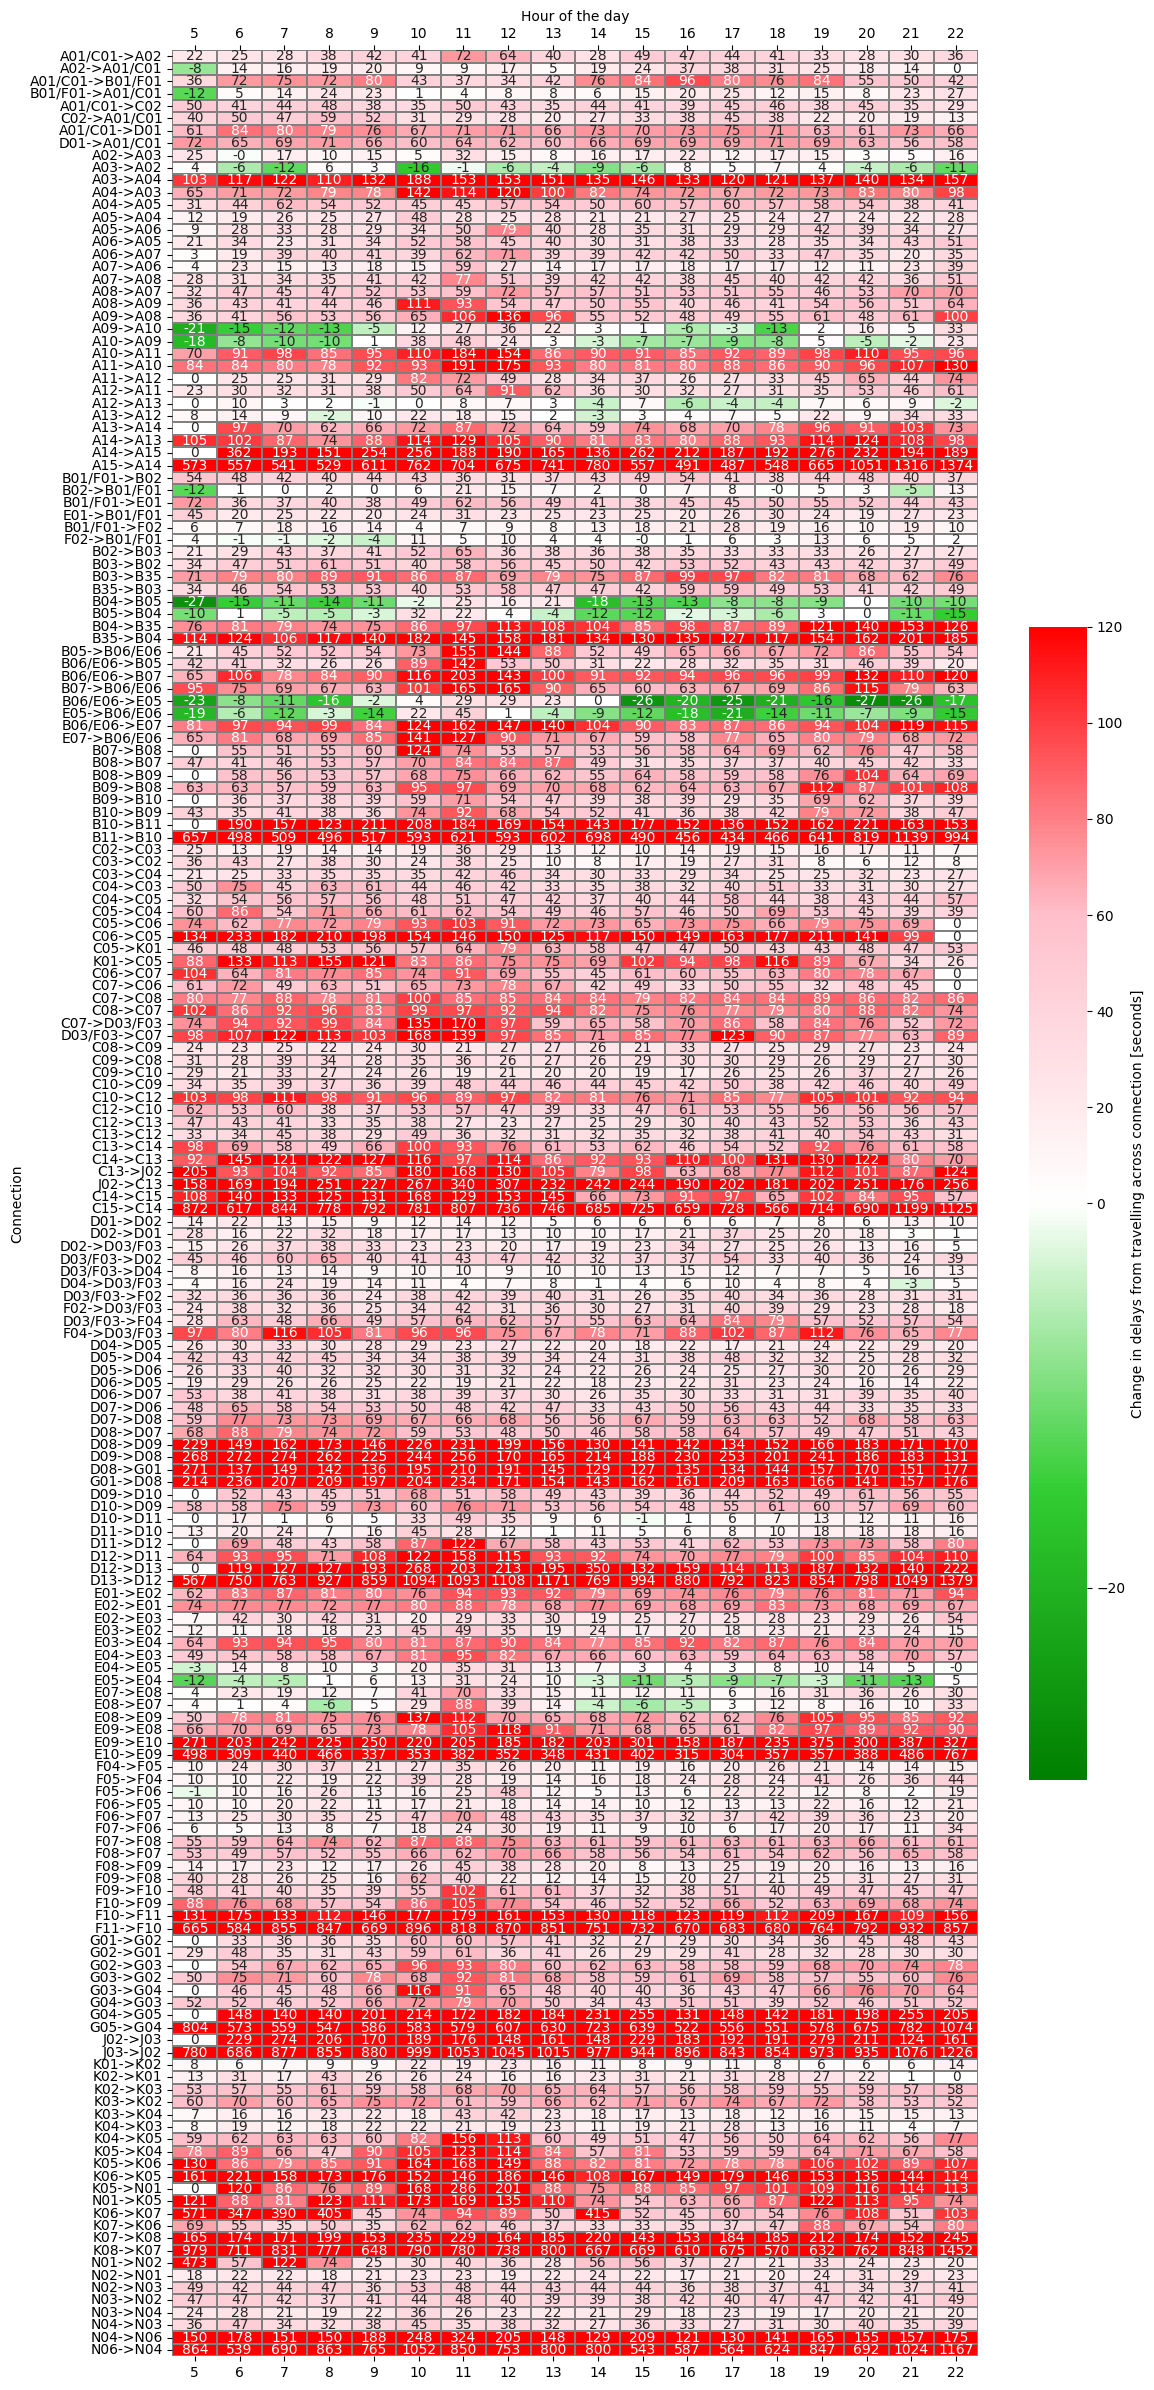

In [8]:
data_dict = {}
stop_pairs = [sorted(list(key)) for key, _ in forward_result_total.groupby(['from_stop', 'to_stop'])]
stop_pairs = np.unique(stop_pairs, axis=0)
stop_pairs.sort()

data_array = []
xticks = [int(timestep) for timestep in forward_result_total['timestep'].unique()]
yticks = []
for stop_pair in stop_pairs:
    # Remove non-existent connections
    if tuple(stop_pair) in [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')]:
                continue

    for stop_pair in [stop_pair, [str(stop_pair[1]), str(stop_pair[0])]]:
        # Remove extreme end-of-line values
        # if tuple(stop_pair) in [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')]:
        #     continue

        functions = forward_result_total[(forward_result_total['from_stop'] == stop_pair[0]) & (forward_result_total['to_stop'] == stop_pair[1])].copy()
        functions = functions.sort_values(by=['timestep'])

        means_i = [0] * len(xticks)
        for _, function in functions.iterrows():
            means_i[int(function['timestep'] - 5)] = function['high']
        
        data_array.append(means_i)
        yticks.append(f"{str(stop_pair[0])}->{str(stop_pair[1])}")
data_array = np.array(data_array)


fig, ax = plt.subplots(figsize=(12, 24))
# cmap = LinearSegmentedColormap.from_list('', ['red', 'pink', 'white', 'chartreuse', 'limegreen'])
cmap = LinearSegmentedColormap.from_list('', ['green', 'limegreen', 'white', 'pink', 'red'])
# divnorm = TwoSlopeNorm(vmin=-60, vcenter=0., vmax=60)

divnorm = TwoSlopeNorm(vmin=-30, vcenter=0, vmax=120)

sns.heatmap(data_array, xticklabels=xticks, yticklabels=yticks, cmap=cmap, annot=True, fmt='.0f', norm=divnorm, ax=ax, 
            cbar_kws={'label': "Change in delays from travelling across connection [seconds]", "shrink": 0.5},linewidths=0.05,linecolor="grey")
# for 
#     ax.add_patch(Rectangle([0, len(yticks)-2], len(xticks), 2, fill=False, edgecolor='black', lw=2, clip_on=False))

ax.set_xlabel('Hour of the day')
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.xaxis.set_label_position('top')
ax.set_ylabel('Connection')

# ax.set_title('Upper bound of 95th percentile confidence interval for \n the effect on delays from travelling across a connection')
# plt.savefig(r'Model results\forward_table.png', dpi=200)
plt.tight_layout()
plt.show()
fig.savefig(r'Codebase figures\\highs_table.png', dpi=200)

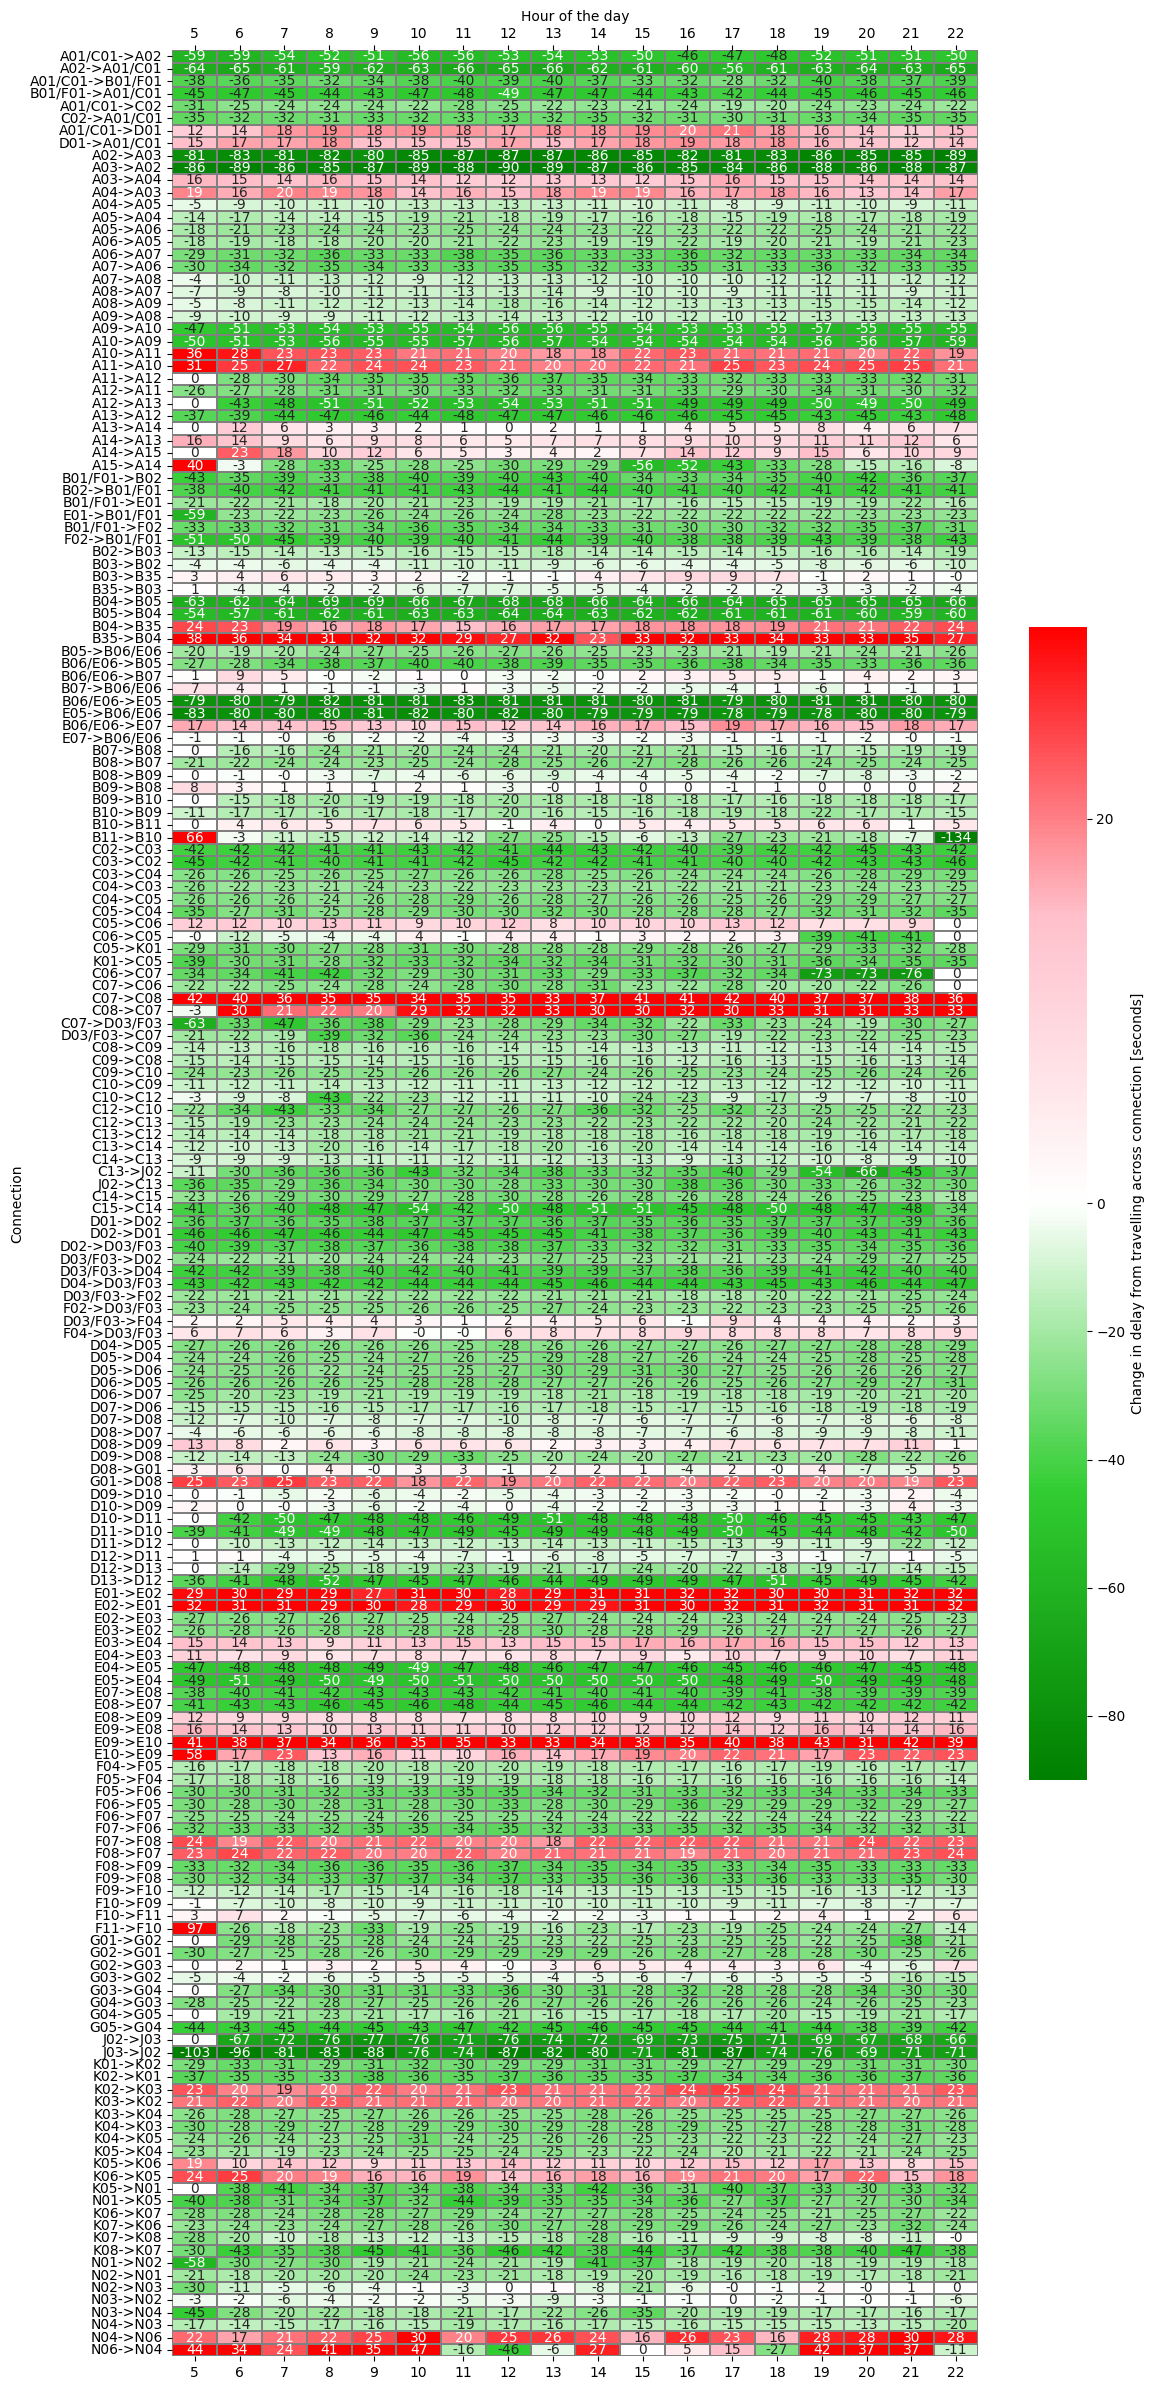

In [9]:
data_dict = {}
stop_pairs = [sorted(list(key)) for key, _ in forward_result_total.groupby(['from_stop', 'to_stop'])]
stop_pairs = np.unique(stop_pairs, axis=0)
stop_pairs.sort()

data_array = []
xticks = [int(timestep) for timestep in forward_result_total['timestep'].unique()]
yticks = []
for stop_pair in stop_pairs:
    # Remove non-existent connections
    if tuple(stop_pair) in [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')]:
                continue

    for stop_pair in [stop_pair, [str(stop_pair[1]), str(stop_pair[0])]]:
        # Remove extreme end-of-line values
        # if tuple(stop_pair) in [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')]:
        #     continue

        functions = forward_result_total[(forward_result_total['from_stop'] == stop_pair[0]) & (forward_result_total['to_stop'] == stop_pair[1])].copy()
        functions = functions.sort_values(by=['timestep'])

        means_i = [0] * len(xticks)
        for _, function in functions.iterrows():
            means_i[int(function['timestep'] - 5)] = function['low']
        
        data_array.append(means_i)
        yticks.append(f"{str(stop_pair[0])}->{str(stop_pair[1])}")
data_array = np.array(data_array)


fig, ax = plt.subplots(figsize=(12, 24))
# cmap = LinearSegmentedColormap.from_list('', ['red', 'pink', 'white', 'chartreuse', 'limegreen'])
cmap = LinearSegmentedColormap.from_list('', ['green', 'limegreen', 'white', 'pink', 'red'])
# divnorm = TwoSlopeNorm(vmin=-60, vcenter=0., vmax=60)

divnorm = TwoSlopeNorm(vmin=-90, vcenter=0, vmax=30)

sns.heatmap(data_array, xticklabels=xticks, yticklabels=yticks, cmap=cmap, annot=True, fmt='.0f', norm=divnorm, ax=ax, 
            cbar_kws={'label': "Change in delay from travelling across connection [seconds]", "shrink": 0.5},linewidths=0.05,linecolor="grey")

# for 
#     ax.add_patch(Rectangle([0, len(yticks)-2], len(xticks), 2, fill=False, edgecolor='black', lw=2, clip_on=False))

ax.set_xlabel('Hour of the day')
ax.tick_params(axis="x", top=True, labeltop=True, bottom=True, labelbottom=True)
ax.xaxis.set_label_position('top')
ax.set_ylabel('Connection')

# ax.set_title('Lower bound of 95th percentile confidence interval for \n the effect on delays from travelling across a connection')
# plt.savefig(r'Model results\forward_table.png', dpi=200)
plt.tight_layout()
plt.show()
fig.savefig(r'Codebase figures\\lows_table.png', dpi=200)

# One station all weekdays

In [15]:
# connection = ('E04', 'E05')
# connection = ('D05', 'D06')
# connection = ('A11', 'A12')
connection = ('C07', 'C08')
# connection = ('A03', 'A02')


data_array = {}
xticks = [int(timestep) for timestep in forward_result_total['timestep'].unique()]
yticks = ['All', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for dist_value in ['high', 'mean', 'low']:
    data_array[dist_value] = []
    # First do total
    connection_funcs = forward_result_total[(forward_result_total['from_stop'] == connection[0]) & (forward_result_total['to_stop'] == connection[1])]
    means_i = [np.nan] * len(xticks)
    for _, function in connection_funcs.iterrows():
        means_i[int(function['timestep'] - 5)] = function[dist_value]
    data_array[dist_value].append(means_i)

    # Then all weekdays
    for _, results_i in weekday_results.items():
        connection_funcs = results_i[(results_i['from_stop'] == connection[0]) & (results_i['to_stop'] == connection[1])]
        means_i = [np.nan] * len(xticks)
        for _, function in connection_funcs.iterrows():
            means_i[int(function['timestep'] - 5)] = function[dist_value]
        data_array[dist_value].append(means_i)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
cmap = LinearSegmentedColormap.from_list('', ['green', 'limegreen', 'white', 'pink', 'red'])
divnorm = TwoSlopeNorm(vmin=-60, vcenter=0, vmax=60)
cbar_ax = fig.add_axes([.91, .2, .02, .6])

for i, ((dist_value, value_data), ax) in enumerate(zip(data_array.items(), [ax1, ax2, ax3])):
    # print(value_data)
    sns.heatmap(value_data, xticklabels=xticks, yticklabels=yticks, cmap=cmap, annot=True, fmt='.0f', norm=divnorm, ax=ax, cbar=i==0, cbar_ax=None if i else cbar_ax,
                cbar_kws={'label': "Change in delay from travelling across connection [seconds]", "shrink": 0.5},linewidths=0.05,linecolor="grey")

ax1.set_ylabel('95th % upper bound')
ax2.set_ylabel('Mean')
ax3.set_ylabel('95th % lower bound')

ax1.xaxis.tick_top()
ax2.set_xticks([])
ax3.set_xticks([])

ax1.set_xlabel('Hour of the day')
ax1.xaxis.set_label_position('top')

fig.supylabel('Day of the week')
plt.show()
fig.savefig(f"Codebase figures\\table_{connection[0]}_{connection[1]}.png", dpi=200)

C:\Users\lange\AppData\Local\Temp\ipykernel_16612\535705810.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Plot all for appendix

In [11]:
import matplotlib
matplotlib.use('Agg')

connections = [connection for connection, _ in forward_result_total.groupby(['from_stop', 'to_stop'])]
NON_EXISTENT_CONNECTIONS = [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')] # Both directions
def filter_out_connections(stop_pair):
    if stop_pair in NON_EXISTENT_CONNECTIONS or (stop_pair[1], stop_pair[0]) in NON_EXISTENT_CONNECTIONS:
        return True
connections = [conn for conn in connections if not filter_out_connections(conn)]

for connection in connections:
    print(connection)
    data_array = {}
    xticks = [int(timestep) for timestep in forward_result_total['timestep'].unique()]
    yticks = ['All', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for dist_value in ['high', 'mean', 'low']:
        data_array[dist_value] = []
        # First do total
        connection_funcs = forward_result_total[(forward_result_total['from_stop'] == connection[0]) & (forward_result_total['to_stop'] == connection[1])]
        means_i = [np.nan] * len(xticks)
        for _, function in connection_funcs.iterrows():
            means_i[int(function['timestep'] - 5)] = function[dist_value]
        data_array[dist_value].append(means_i)

        # Then all weekdays
        for _, results_i in weekday_results.items():
            connection_funcs = results_i[(results_i['from_stop'] == connection[0]) & (results_i['to_stop'] == connection[1])]
            means_i = [np.nan] * len(xticks)
            for _, function in connection_funcs.iterrows():
                means_i[int(function['timestep'] - 5)] = function[dist_value]
            data_array[dist_value].append(means_i)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    cmap = LinearSegmentedColormap.from_list('', ['green', 'limegreen', 'white', 'pink', 'red'])
    divnorm = TwoSlopeNorm(vmin=-60, vcenter=0, vmax=60)
    cbar_ax = fig.add_axes([.91, .2, .02, .6])

    for i, ((dist_value, value_data), ax) in enumerate(zip(data_array.items(), [ax1, ax2, ax3])):
        # print(value_data)
        sns.heatmap(value_data, xticklabels=xticks, yticklabels=yticks, cmap=cmap, annot=True, fmt='.0f', norm=divnorm, ax=ax, cbar=i==0, cbar_ax=None if i else cbar_ax,
                    cbar_kws={'label': "Change in delay from travelling across connection [seconds]", "shrink": 0.5},linewidths=0.05,linecolor="grey")

    ax1.set_ylabel('95th % upper bound')
    ax2.set_ylabel('Mean')
    ax3.set_ylabel('95th % lower bound')

    ax1.xaxis.tick_top()
    ax2.set_xticks([])
    ax3.set_xticks([])

    ax1.set_xlabel('Hour of the day')
    ax1.xaxis.set_label_position('top')

    from_stop_name = connection[0]
    to_stop_name = connection[1]
    if '/' in from_stop_name:
        from_stop_name = from_stop_name.replace('/', '-')
    if '/' in to_stop_name:
        to_stop_name = to_stop_name.replace('/', '-')

    fig.supylabel('Day of the week')
    fig.savefig(f"Second model appendix figures\\appendix_table_{from_stop_name}_{to_stop_name}.png", dpi=80)

('A01/C01', 'A02')
('A01/C01', 'B01/F01')
('A01/C01', 'C02')
('A01/C01', 'D01')
('A02', 'A01/C01')
('A02', 'A03')
('A03', 'A02')
('A03', 'A04')
('A04', 'A03')
('A04', 'A05')
('A05', 'A04')
('A05', 'A06')
('A06', 'A05')
('A06', 'A07')
('A07', 'A06')
('A07', 'A08')
('A08', 'A07')
('A08', 'A09')
('A09', 'A08')
('A09', 'A10')
('A10', 'A09')


C:\Users\lange\AppData\Local\Temp\ipykernel_16612\42717800.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))


('A10', 'A11')
('A11', 'A10')
('A11', 'A12')
('A12', 'A11')
('A12', 'A13')
('A13', 'A12')
('A13', 'A14')
('A14', 'A13')
('A14', 'A15')
('A15', 'A14')
('B01/F01', 'A01/C01')
('B01/F01', 'B02')
('B01/F01', 'E01')
('B01/F01', 'F02')
('B02', 'B01/F01')
('B02', 'B03')
('B03', 'B02')
('B03', 'B35')
('B04', 'B05')
('B04', 'B35')
('B05', 'B04')
('B05', 'B06/E06')
('B06/E06', 'B05')
('B06/E06', 'B07')
('B06/E06', 'E05')
('B06/E06', 'E07')
('B07', 'B06/E06')
('B07', 'B08')
('B08', 'B07')
('B08', 'B09')
('B09', 'B08')
('B09', 'B10')
('B10', 'B09')
('B10', 'B11')
('B11', 'B10')
('B35', 'B03')
('B35', 'B04')
('C02', 'A01/C01')
('C02', 'C03')
('C03', 'C02')
('C03', 'C04')
('C04', 'C03')
('C04', 'C05')
('C05', 'C04')
('C05', 'C06')
('C05', 'K01')
('C06', 'C05')
('C06', 'C07')
('C07', 'C06')
('C07', 'C08')
('C07', 'D03/F03')
('C08', 'C07')
('C08', 'C09')
('C09', 'C08')
('C09', 'C10')
('C10', 'C09')
('C10', 'C12')
('C12', 'C10')
('C12', 'C13')
('C13', 'C12')
('C13', 'C14')
('C13', 'J02')
('C14', 'C13')